In [ ]:
# # !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/

In [ ]:
# !kaggle datasets download -d salader/dogs-vs-cats

 99% 1.06G/1.06G [00:07<00:00, 141MB/s]
100% 1.06G/1.06G [00:07<00:00, 162MB/s]


In [1]:
# import zipfile
# zip_ref = zipfile.ZipFile('/input/content/monkeypox.zip', 'r')
# zip_ref.extractall('/kaggle/working/monkeypox')
# zip_ref.close()

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import keras_tuner as kt
from sklearn.metrics import roc_auc_score, confusion_matrix
import seaborn as sns

2025-07-09 14:57:28.517028: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752073048.884900      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752073048.984718      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
conv_base = InceptionV3(
    weights='imagenet',
    include_top = False,
    input_shape=(224,224,3)
)

I0000 00:00:1752073070.648675      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752073070.649348      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

In [4]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Reduce learning rate by a factor of 0.2
    patience=3,  # Wait 3 epochs before reducing
    min_lr=1e-6  # Minimum learning rate
)

In [8]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define data augmentation as a keras Sequential model
data_augmentation = keras.Sequential([
    # layers.RandomFlip("horizontal"),
    # layers.RandomRotation(0.2),  # Increase rotation
    # layers.RandomZoom(0.3),
    # layers.RandomTranslation(0.2, 0.2),
    # layers.RandomContrast(0.2),  # Add contrast adjustment
    # layers.RandomBrightness(0.2)# Add brightness adjustment
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])
# Load datasets from your directories (with your exact paths)
train_ds = keras.utils.image_dataset_from_directory(
    directory='/kaggle/input/content/Fold1/Fold1/Fold1/Train',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory='/kaggle/input/content/Fold1/Fold1/Fold1/Val',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224)
)

# Function to apply augmentation and normalization to training data
def process_train(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    image = data_augmentation(image)            # Apply augmentation
    return image, label

# Function to normalize validation data only
def process_val(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    return image, label

# Apply the processing functions
train_ds = train_ds.map(process_train, num_parallel_calls=tf.data.AUTOTUNE)
validation_ds = validation_ds.map(process_val, num_parallel_calls=tf.data.AUTOTUNE)

# Prefetch for performance
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
validation_ds = validation_ds.prefetch(tf.data.AUTOTUNE)

Found 2142 files belonging to 2 classes.
Found 420 files belonging to 2 classes.


In [9]:
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3



# Unfreeze top 20 layers of InceptionV3
for layer in conv_base.layers[-20:]:
    layer.trainable = True

# Freeze all layers initially
conv_base.trainable = False

def build_model(hp):
    model = Sequential()
    model.add(conv_base)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(
        units=hp.Int('units', min_value=128, max_value=512, step=128),
        activation='relu'
    ))
    # model.add(Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1)))
    model.add(Dropout(.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-5, 1e-3, sampling='log')
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,
    executions_per_trial=2,
    directory='tuner_dir',
    project_name='inceptionv3_tuning'
)
tuner.search(train_ds, validation_data=validation_ds, epochs=5)
best_model = tuner.get_best_models(num_models=1)[0]

Trial 3 Complete [00h 02m 36s]
val_accuracy: 0.7809523642063141

Best val_accuracy So Far: 0.7964285910129547
Total elapsed time: 00h 08m 06s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [19]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint
# Optional: Get the best hyperparameters for reference
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# Create output directory
output_dir = '/kaggle/working/inceptionv3_models/'
os.makedirs(output_dir, exist_ok=True)
best_model.save(os.path.join(output_dir, 'best_model.keras'))
best_model.save_weights(os.path.join(output_dir, 'best_model_weights.weights.h5'))
print(f"Best units: {best_hps.get('units')}")
# print(f"Best dropout: {best_hps.get('dropout')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")

# Define callbacks for further training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_finetuned_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

# Optional: Compute class weights for imbalanced data
# from sklearn.utils import class_weight
# import numpy as np
# y_train = np.concatenate([labels.numpy() for _, labels in train_ds])
# class_weights = class_weight.compute_class_weight(
#     class_weight='balanced', classes=np.unique(y_train), y=y_train
# )
# class_weights = dict(enumerate(class_weights))

# Further train the best model
history = best_model.fit(
    train_ds,
    epochs=50,  # Train for more epochs
    validation_data=validation_ds,
    # class_weight=class_weights,  # Apply class weights if needed
    # callbacks=[early_stopping, reduce_lr, checkpoint]
)

# Evaluate the model on test dataset
# loss, accuracy = best_model.evaluate(test_ds)
# print(f"Test Loss: {loss:.4f}")
# print(f"Test Accuracy: {accuracy:.4f}")

Best units: 384
Best learning rate: 0.00020776644996253494
Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 0.9372 - loss: 0.1783 - val_accuracy: 0.7905 - val_loss: 0.4615
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.9262 - loss: 0.1840 - val_accuracy: 0.7857 - val_loss: 0.4663
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.9473 - loss: 0.1618 - val_accuracy: 0.7929 - val_loss: 0.4675
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.9379 - loss: 0.1689 - val_accuracy: 0.7881 - val_loss: 0.4723
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 0.9469 - loss: 0.1679 - val_accuracy: 0.7881 - val_loss: 0.4687
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 0.9493 - loss: 0.1561 - val_accuracy: 0.7881 - val_loss: 0.4669
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 0.9454 - loss: 0.1567 - val_accuracy: 0.7857 - val_loss: 0.4680
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 

In [11]:

import json
import pickle

# Save best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
with open(os.path.join(output_dir, 'best_hyperparameters.json'), 'w') as f:
    json.dump(best_hps.values, f, indent=4)

# Save trials summary
trials_summary = [
    {
        'trial_id': trial.trial_id,
        'hyperparameters': trial.hyperparameters.values,
        'score': trial.score,
        'status': trial.status
    } for trial in tuner.oracle.trials.values()
]
with open(os.path.join(output_dir, 'trials_summary.json'), 'w') as f:
    json.dump(trials_summary, f, indent=4)

# Save training history
with open(os.path.join(output_dir, 'training_history.pkl'), 'wb') as f:
    pickle.dump(history.history, f)

# Save trials history
best_trials = tuner.oracle.get_best_trials(num_trials=5)
trials_history = {trial.trial_id: trial.metrics.get_history() for trial in best_trials}
with open(os.path.join(output_dir, 'trials_history.pkl'), 'wb') as f:
    pickle.dump(trials_history, f)

# Create ZIP archive
shutil.make_archive('/kaggle/working/inceptionv3_models', 'zip', output_dir)
print("All files saved in", output_dir)
print("ZIP archive created at /kaggle/working/inceptionv3_models.zip")

TypeError: MetricsTracker.get_history() missing 1 required positional argument: 'name'

In [20]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 384)                 │         786,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             385 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,164,389 (92.18 MB)

 Trainable params: 787,201 (3.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

 Optimizer params: 1,574,404 (6.01 MB)

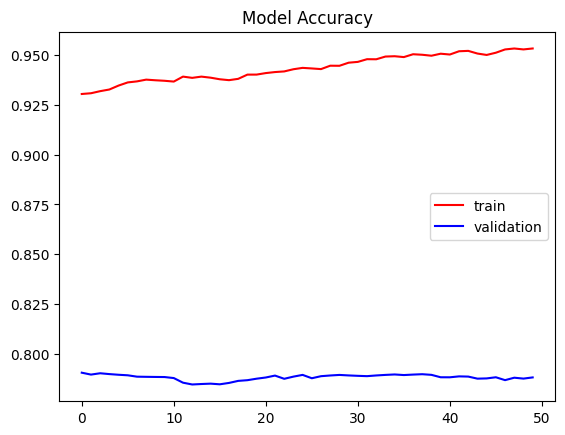

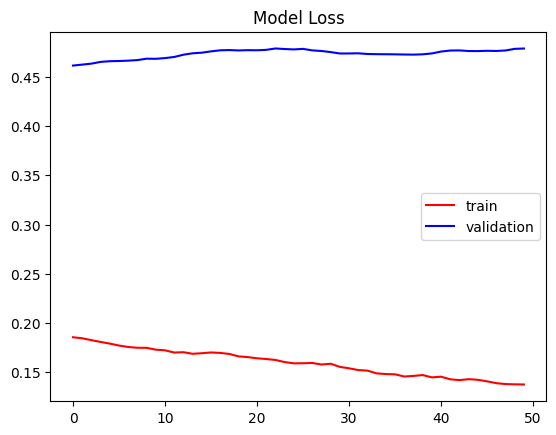

In [21]:
import matplotlib.pyplot as plt
# Plot training curves
def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            smoothed.append(smoothed[-1] * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

plt.plot(smooth_curve(history.history['accuracy']), color='red', label='train')
plt.plot(smooth_curve(history.history['val_accuracy']), color='blue', label='validation')
plt.title('Model Accuracy')
plt.legend()
plt.show()

plt.plot(smooth_curve(history.history['loss']), color='red', label='train')
plt.plot(smooth_curve(history.history['val_loss']), color='blue', label='validation')
plt.title('Model Loss')
plt.legend()
plt.show()

Found 2142 files belonging to 2 classes.
Found 420 files belonging to 2 classes.


In [22]:
# Load the Validation Dataset

from tensorflow.keras.utils import image_dataset_from_directory

test_dir = '/kaggle/input/content/Fold1/Fold1/Fold1/Test'

test_ds = image_dataset_from_directory(
    directory=test_dir,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(150, 150)
)
# Evaluate the model on test dataset
loss, accuracy = best_model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Found 45 files belonging to 2 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6988 - loss: 20.9519
Test Loss: 21.0476
Test Accuracy: 0.6889


In [15]:
# Evaluate on test set
loss, accuracy = best_model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6380 - loss: 10.7546
Test Loss: 10.6735
Test Accuracy: 0.6444


In [23]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, roc_auc_score

# Classification report and AUC
y_true = []
y_pred_probs = []

# Resize images to (224, 224) to match InceptionV3 input requirements
def resize_image(image, label):
    image = tf.image.resize(image, [224, 224])  # Resize to (224, 224)
    return image, label

# Apply resizing to the test dataset
test_ds_resized = test_ds.map(resize_image, num_parallel_calls=tf.data.AUTOTUNE)

# Predict on resized test dataset
for images, labels in test_ds_resized:
    preds = best_model.predict(images).flatten()  # Predict probabilities
    y_true.extend(labels.numpy())  # True labels
    y_pred_probs.extend(preds)     # Predicted probabilities

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)

# Classification report
class_names = test_ds.class_names
print(classification_report(y_true, (y_pred_probs > 0.5).astype(int), target_names=class_names))

# AUC-ROC
auc = roc_auc_score(y_true, y_pred_probs)
print(f"AUC-ROC: {auc:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
              precision    recall  f1-score   support

   Monkeypox       0.61      0.55      0.58        20
      Others       0.67      0.72      0.69        25

    accuracy                           0.64        45
   macro avg       0.64      0.64      0.64        45
weighted avg       0.64      0.64      0.64        45

AUC-ROC: 0.6620


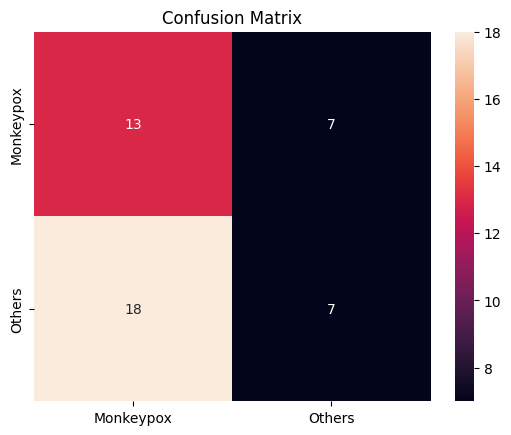

In [17]:
# Confusion matrix
cm = confusion_matrix(y_true, (np.array(y_pred_probs) > 0.5).astype(int))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.show()

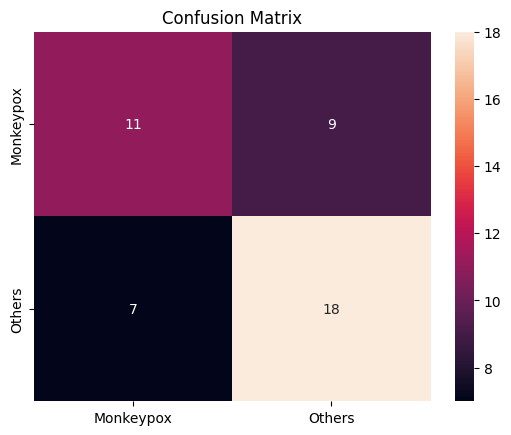

In [24]:
# Confusion matrix
cm = confusion_matrix(y_true, (np.array(y_pred_probs) > 0.5).astype(int))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

y_true = []
y_pred = []

for images, labels in validation_ds:
    preds = model.predict(images).flatten()
    pred_labels = (preds > 0.5).astype(int)
    y_true.extend(labels.numpy())
    y_pred.extend(pred_labels)
class_name=["monkeypox","others"]
class_names = validation_ds.class_names  # ['monkeypox', 'others']

print(classification_report(y_true, y_pred, target_names=class_names))


In [ ]:
# Load the Validation Dataset

from tensorflow.keras.utils import image_dataset_from_directory

test_dir = '/content/Fold1/Fold1/Fold1/Test'

test_ds = image_dataset_from_directory(
    directory=test_dir,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224)
)
# Normalize images
def preprocess(image, label):
    image = tf.cast(image / 255.0, tf.float32)
    return image, label

test_ds = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


In [ ]:
import os
from collections import Counter

train_dir = "/content/Fold1/Fold1/Fold1/Train"
print("Train class counts:")
for label in os.listdir(train_dir):
    count = len(os.listdir(os.path.join(train_dir, label)))
    print(f"{label}: {count}")


Train class counts:
Others: 1162
Monkeypox: 980
